<h3>Embedding Map Extraction</h3>

import tensorflow as tf

In [1]:
%%time
from PIL.Image import open
from numpy import array, float32, reshape, expand_dims, argmax
from numpy.random import rand
from watermarking import extraction, cnn

Wall time: 650 ms


In [2]:
import numpy as np

In [3]:
ground_truth = array(open("Watermark.tiff"), dtype=float32)

In [4]:
import matplotlib.pyplot as plt

## Convolution Testing

In [5]:
from watermarking import extraction, process, forward, cnn, attacks

In [6]:
image = open("static/training/airplane.tif")

In [7]:
attacked = attacks.Attacks(process.Process.pil_to_open_cv(image)).do_transformation(attacks.Attacks.MEDIAN_BLUR, 5)
attacked2 = attacks.Attacks(process.Process.pil_to_open_cv(image)).do_transformation(attacks.Attacks.GAUSSIAN_BLUR, 3)

In [8]:
ext = extraction.Extraction()

In [9]:
key = ext.extract_key_from_pil_image(image)

In [10]:
result = ext.get_embedding_map(process.Process.pil_to_open_cv(image), key)

In [11]:
array(result).max()

219.00000000000003

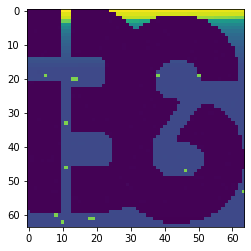

In [12]:
plt.imshow(result)

In [13]:
norm_image = []
for row in result:
    norm_row = []
    for _px in row:
        norm_row.append(float(round(_px)))
    norm_image.append(norm_row)
# norm_image2 = []
# for row in attacked:
#     norm_row = []
#     for _px in row:
#         norm_row.append(float(round(_px)))
#     norm_image2.append(norm_row)
# norm_image3 = []
# for row in attacked2:
#     norm_row = []
#     for _px in row:
#         norm_row.append(float(round(_px)))
#     norm_image3.append(norm_row)

In [14]:
f = forward.Forward(
    False,
    [
        [norm_image]
    ], # double array as batch and channel
    cnn.CNN.init_params()
)

initializing
enc   0  ->  64
dec   0  ->  64
 (1, 1, 64, 64)


In [15]:
result = f.run()

encoder
shape:  (1, 1, 64, 64)
STACK: 0
ReLU and max pool
decoder
shape:  (1, 8, 32, 32)
STACK: 0
ups and conv
decoded:  (1, 1, 64, 64)


In [16]:
array(result).shape

(64, 64)

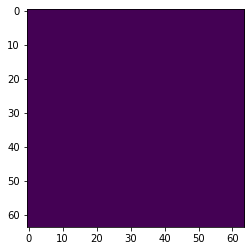

In [17]:
plt.imshow(result)

In [18]:
conved_images = []
for batch, image in enumerate([[norm_image]]):
    conved_images.append(
        f.conv_per_stack(
            image, f.ENCODER, 0, batch
        )
    )

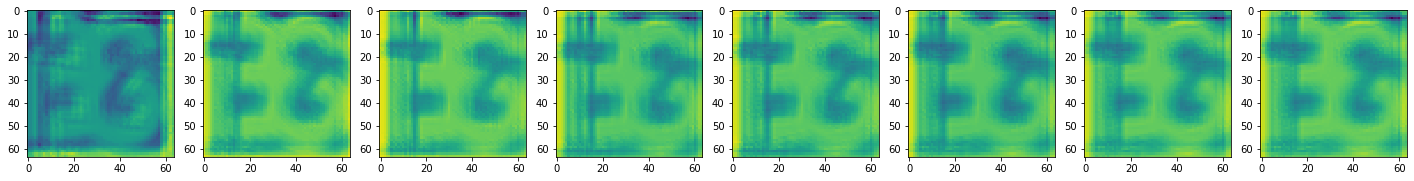

In [19]:
fig = plt.figure(figsize=(50, 50))
for i in range(len(conved_images[0])):
    sub = fig.add_subplot(2, 16, i + 1)
    sub.imshow(conved_images[0][i], interpolation='nearest')

In [20]:
conved_images = array(conved_images)

In [21]:
conved_images

array([[[[-8.74092352e+01, -9.27941669e+01, -8.55886178e+01, ...,
          -3.55830203e+01, -1.96478713e+01, -4.81552092e+01],
         [-1.00865960e+02, -1.06717455e+02, -9.17395242e+01, ...,
          -5.31755376e+01, -4.93424806e+01, -1.11531020e+02],
         [-1.07883332e+02, -1.11450932e+02, -9.21837646e+01, ...,
           7.51556430e+01,  8.95433409e+01, -9.76533278e+00],
         ...,
         [-9.40433327e+01, -9.57637436e+01, -7.73692379e+01, ...,
           5.45937262e+01,  6.77878956e+01,  1.42846678e+01],
         [-4.25353965e+01, -3.14882968e+01, -3.21016867e+00, ...,
           5.77270650e+01,  5.54299636e+01,  1.69894011e+01],
         [-2.07287219e+01, -2.05603675e+01, -1.27827201e+01, ...,
           5.34925684e+01,  6.00258839e+01,  3.81567699e+01]],

        [[-1.75962071e+02, -2.26449772e+02, -2.75955516e+02, ...,
          -1.28158057e+03, -1.02910975e+03, -7.86932708e+02],
         [-2.39008492e+02, -3.33681535e+02, -4.17282520e+02, ...,
          -2.53960924e

In [22]:
processed_conv = []
for batch, image in enumerate(conved_images):
    image = f.relu_per_stack(image, batch)
#     image = f.max_pooling_per_stack(image, batch)
    processed_conv.append(image)

In [23]:
processed_conv = array(processed_conv)

In [24]:
processed_conv.shape

(1, 8, 64, 64)

In [26]:
processed_conv

array([[[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ..., 75.15564299,
          89.54334087,  0.        ],
         ...,
         [ 0.        ,  0.        ,  0.        , ..., 54.59372622,
          67.78789559, 14.28466784],
         [ 0.        ,  0.        ,  0.        , ..., 57.72706505,
          55.42996359, 16.98940106],
         [ 0.        ,  0.        ,  0.        , ..., 53.49256844,
          60.02588389, 38.15676991]],

        [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         ...,
         [ 0.        ,  0.        

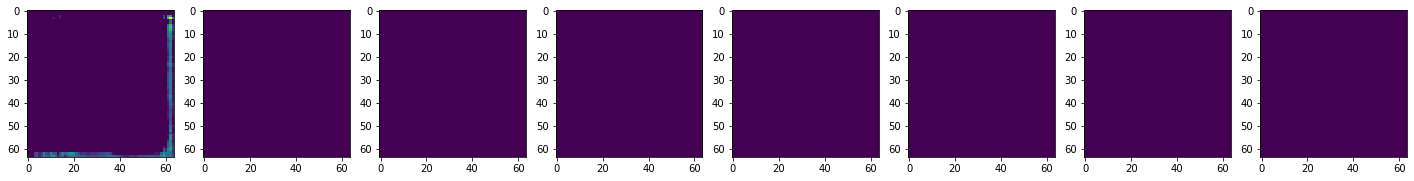

In [25]:
fig = plt.figure(figsize=(50, 50))
for i in range(len(processed_conv[0])):
    sub = fig.add_subplot(2, 16, i + 1)
    sub.imshow(processed_conv[0][i], interpolation='nearest')

In [ ]:
processed = []
for batch, image in enumerate(processed_conv):
    image = f.upsample_per_stack(
        image, batch, 0
    )
    processed.append(image)

In [ ]:
fig = plt.figure(figsize=(50, 50))
for i in range(len(processed[0])):
    sub = fig.add_subplot(2, 16, i + 1)
    sub.imshow(processed[0][i], interpolation='nearest')

In [ ]:
decoded = []
for batch, image in enumerate(processed):
    image = f.conv_per_stack(
        image, f.DECODER, 0, batch
    )
    decoded.append(image)

In [ ]:
plt.imshow(decoded[0][0])

In [ ]:
sm = f.softmax_per_batch(decoded)

In [ ]:
plt.imshow(sm)

# Checking Convolution

In [ ]:
from watermarking import training

In [ ]:
%%time
train = training.Training()

In [ ]:
%%time
epoch = 10
losses = []
accs = []
for i in range(0, epoch):
    print('EPOCH: ', i)
    result, loss, acc, attacked_wm = train.auto_training()
    losses.append(loss)
    accs.append(acc)

In [ ]:
train.store_params()

In [ ]:

ground_truth = array(ground_truth)
max_result = -1
chosen_img = None
for data in sm:
    background, foreground = data
    classified = []
    for i, row in enumerate(background):
        new_row = []
        for j, _px in enumerate(row):
            new_row.append(
                0 if _px > foreground[i][j] else 255
            )
        classified.append(new_row)
    classified = array(classified)
    a = ground_truth.ravel()
    b = classified.ravel()
    
    a = (a - np.mean(a)) / (np.std(a) * len(a))
    b = (b - np.mean(b)) / (np.std(b))
    c = np.correlate(a, b, 'full')
    
    if c.max() > max_result:
        max_result = c.max()
        chosen_img = classified
    print(c.max())

In [ ]:
plt.imshow(result[0][0])

In [ ]:
plt.imshow(cnn.CNN.softmax_classifier(result[0][0], result[0][1]))

In [ ]:
plt.imshow(chosen_img)

In [ ]:
print(len(result))
print(max_result)

In [ ]:
a = ground_truth.ravel()
b = array(sm).ravel()

In [ ]:
a = (a - np.mean(a)) / (np.std(a) * len(a))
b = (b - np.mean(b)) / (np.std(b))
c = np.correlate(a, b, 'full')

In [ ]:
c.max()

In [ ]:
ground_truth

In [ ]:
array(sm)

<h3> Create Graph from Result</h3>

<h5>Attacks</h5>

In [ ]:
accs = array(accs) # epoch, image, attack

In [ ]:
accs.shape

<h4>Check NC of forward only</h4>

In [ ]:
from copy import deepcopy
from watermarking import embedding

In [ ]:
print(embedding.Embedding.normalized_correlation_coef(softmax[0], ground_truth))

<h4>Try to classify softmax better</h4>

In [ ]:
classified = []
for row in softmax[0]:
    new_row = []
    for pixel in row:
        if pixel > 1:
            pixel = 1
        elif pixel < 0:
            pixel = 0
        else:
            pixel = round(pixel)
        new_row.append(pixel)
    classified.append(new_row)

In [ ]:
print(embedding.Embedding.normalized_correlation_coef(classified, ground_truth))